# Autoencoder Testing

In [2]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
import regex as re
from tqdm.notebook import tqdm
import scipy

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

from IPython.display import clear_output

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tqdm.keras import TqdmCallback

In [3]:
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Here we'll implement a variety of structures for the autoencoder to ensure that we have an accurate autoencoder.

### Feature Creation

In [4]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../../../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../../../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)
    
    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
rt_usernames = list(pd.read_csv('../../../Data/AuthUserNames.txt', header=None)[0])
non_rt_users = [un for un in authentication_data['UserName'].unique() if un not in rt_usernames]
non_rt_sample = pickle.load (open('Random Sample of Non Red Team Usernames.p','rb'))

In [6]:
a_t = list(authentication_data['Authent Type'].unique())
AT_dict = { i : a_t[i] for i in range(0, len(a_t) ) }

In [7]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

In [8]:
def split_dataframe(df,n):
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [9]:
def feature_generation(user,n):
    
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data[data['UserName'] == user].groupby(['SrcDevice','DstDevice']).size())
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
                #feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                feat_dict[i*n + j] = [day,srcunique,dstunique,uniquepairs,authents,failures]
                
    #df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df1 = pd.DataFrame(data=feat_dict,index =  ['Day','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df1 = df1.transpose()
    df1 = df1.fillna(0)
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    df = pd.concat([df1, auth_type_df], axis=1)
    
    return df

In [13]:
rt_count_dframes = []
norm_count_dframes = []

for i,un in tqdm(enumerate(set(rt_usernames))):
    df = feature_generation(un,24)
    rt_count_dframes.append(df)

for i,un in tqdm(enumerate(non_rt_sample)):
    df = feature_generation(un,24)
    norm_count_dframes.append(df)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Autoencoder

In [10]:
def ae_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    data['Hour'] = [j_idx]*len(data)
    data['Day'] = [i_idx+1]*len(data)
    
    return data

In [11]:
def simple_ae_eval(anomaly_bools,anomalies,val_losses,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    final_losses = []
    for i in range(len(val_losses)):
        final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

    plt.figure()
    sns.boxplot(data = final_losses)
    plt.show()
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

#### Current Autoencoder

In [14]:
def ae_anomaly_finder(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [15]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00072: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:09:19.942938


In [16]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:16:37.194846


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
27.77% of the red team data was identified as anomalous.


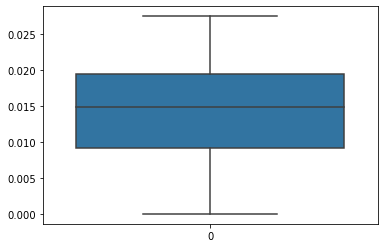

Authent Type
Batch                     487
CachedInteractive         181
InteractiveLogon         1127
NetworkLogon            14486
RemoteInteractive         364
ScreensaverDismissed      479
ScreensaverInvoked        475
Service                   827
TGS                     16867
TGT                      4263
WorkstationLock          1152
WorkstationUnlock        1457
dtype: int64


In [17]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')

179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


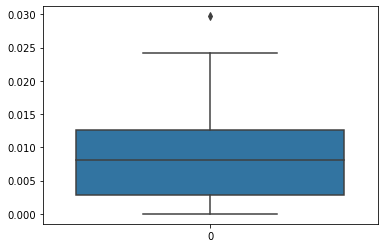

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [18]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### Without Dropout

In [19]:
def ae_anomaly_finder_dropremov(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(2, activation='elu'),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [20]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder_dropremov(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:08:53.390761


In [21]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder_dropremov(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:16:36.797255


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
29.84% of the red team data was identified as anomalous.


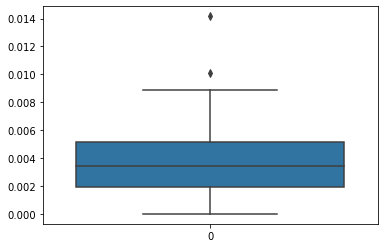

Authent Type
Batch                     547
CachedInteractive         187
InteractiveLogon         1185
NetworkLogon            15966
RemoteInteractive         402
ScreensaverDismissed      484
ScreensaverInvoked        476
Service                  1089
TGS                     17602
TGT                      4731
WorkstationLock          1160
WorkstationUnlock        1467
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


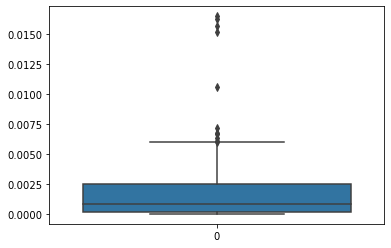

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [22]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### Only reducing to 6 nodes

In [23]:
def ae_anomaly_finder_6n(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [24]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder_6n(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:08:32.664567


In [25]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder_6n(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:15:13.890547


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
28.04% of the red team data was identified as anomalous.


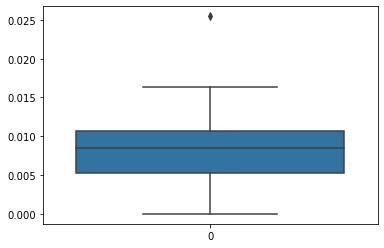

Authent Type
Batch                     488
CachedInteractive         184
InteractiveLogon         1111
NetworkLogon            14711
RemoteInteractive         370
ScreensaverDismissed      484
ScreensaverInvoked        476
Service                   820
TGS                     16988
TGT                      4320
WorkstationLock          1156
WorkstationUnlock        1466
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


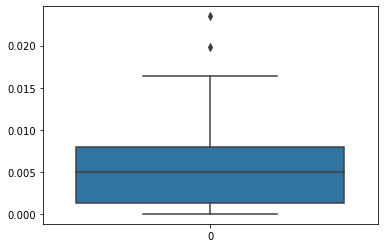

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [26]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### Reducing by 1 instead of 2

In [27]:
def ae_anomaly_finder_1r(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [28]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder_1r(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:08:30.953750


In [29]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder_1r(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:16:48.375858


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
29.18% of the red team data was identified as anomalous.


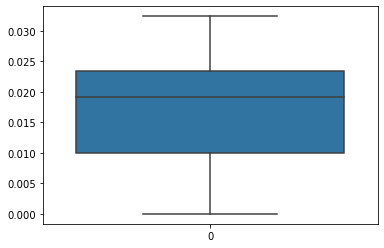

Authent Type
Batch                     504
CachedInteractive         178
InteractiveLogon         1137
NetworkLogon            15577
RemoteInteractive         391
ScreensaverDismissed      481
ScreensaverInvoked        474
Service                  1071
TGS                     17302
TGT                      4570
WorkstationLock          1152
WorkstationUnlock        1460
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


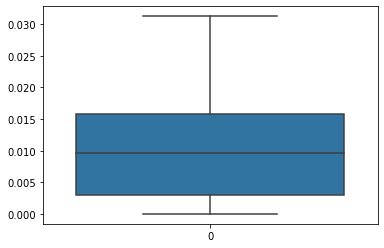

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [30]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### Double Stacked Autoencoder

In [32]:
def ae_anomaly_finder_ds(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu'),
        
        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')


    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [33]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder_ds(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:11:38.014894


In [34]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder_ds(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:24:30.139848


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
30.10% of the red team data was identified as anomalous.


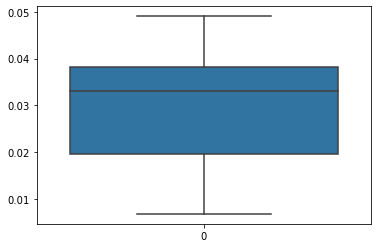

Authent Type
Batch                     562
CachedInteractive         187
InteractiveLogon         1212
NetworkLogon            16135
RemoteInteractive         404
ScreensaverDismissed      484
ScreensaverInvoked        476
Service                  1113
TGS                     17730
TGT                      4760
WorkstationLock          1160
WorkstationUnlock        1467
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


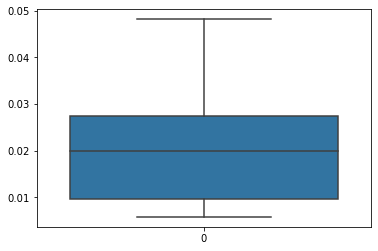

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [35]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### Quadruple Stacked Autoencoder

In [36]:
def ae_anomaly_finder_qs(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu'),
        
        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu'),
        
        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu'),
        
        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(3, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(5, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(7, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(9, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(11, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(13, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(15, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [37]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder_ds(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:11:49.038798


In [38]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder_ds(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:24:48.771687


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
30.17% of the red team data was identified as anomalous.


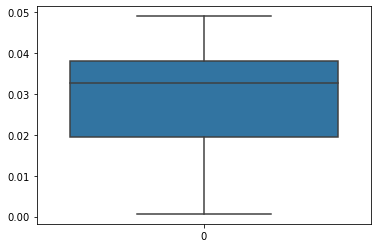

Authent Type
Batch                     566
CachedInteractive         187
InteractiveLogon         1216
NetworkLogon            16182
RemoteInteractive         404
ScreensaverDismissed      484
ScreensaverInvoked        476
Service                  1131
TGS                     17760
TGT                      4772
WorkstationLock          1160
WorkstationUnlock        1467
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


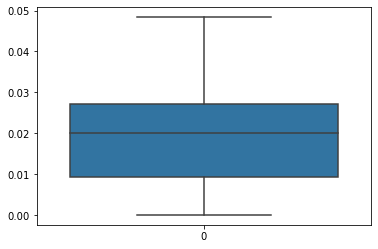

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [39]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### RELU activation

In [41]:
def ae_anomaly_finder_relu(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='relu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [42]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder_relu(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:07:30.582269


In [43]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder_relu(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:15:17.757949


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
29.11% of the red team data was identified as anomalous.


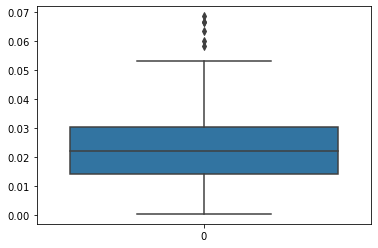

Authent Type
Batch                     551
CachedInteractive         186
InteractiveLogon         1183
NetworkLogon            15418
RemoteInteractive         399
ScreensaverDismissed      484
ScreensaverInvoked        475
Service                   995
TGS                     17293
TGT                      4594
WorkstationLock          1154
WorkstationUnlock        1458
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
28.97% of the normal data was identified as anomalous.


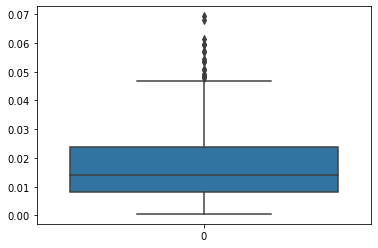

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             8973
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12595
TGT                      3167
WorkstationLock           641
WorkstationUnlock         862
dtype: int64


In [44]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

#### Sigmoid activation

This is usable because we transform our data through normalisation and minmax scaling to be within [-1,1].

In [45]:
def ae_anomaly_finder_sigmoid(user,df,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the train/test sets
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='sigmoid', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='sigmoid'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='sigmoid')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

In [46]:
frames_5 = []
anomaly_bool_5 = []
val_loss_5 = []

s_time = datetime.datetime.now()

for i,un in enumerate(set(rt_usernames)):
    clear_output(wait=True)
    print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
    df = rt_count_dframes[i]
    f,b,val = ae_anomaly_finder_relu(un,df,24)
    if b == 1:
        frames_5.append(f)
        anomaly_bool_5.append((len(f),un))
        val_loss_5.append((val,un))
    else:
        anomaly_bool_5.append((0,un))
        val_loss_5.append((val,un))
        pass
anomalies_ae_5 = pd.concat(frames_5)

e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:07:43.701484


In [47]:
frames_n_5 = []
anomaly_bool_N_5 = []
val_loss_n_5 = []
bound = 400

s_time = datetime.datetime.now()

for i,un in enumerate(non_rt_sample):
    df = norm_count_dframes[i]
    f,b,val = ae_anomaly_finder_relu(un,df,24)
    if b == 1:
        frames_n_5.append(f)
        anomaly_bool_N_5.append((len(f),un))
        val_loss_n_5.append((val,un))
    else:
        anomaly_bool_N_5.append((0,un))
        val_loss_n_5.append((val,un))
        pass
anomalies_ae_n_5 = pd.concat(frames_n_5)
e_time = datetime.datetime.now()
print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:15:14.154711


94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
27.97% of the red team data was identified as anomalous.


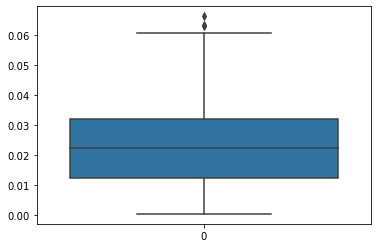

Authent Type
Batch                     478
CachedInteractive         180
InteractiveLogon         1115
NetworkLogon            14637
RemoteInteractive         363
ScreensaverDismissed      482
ScreensaverInvoked        471
Service                   853
TGS                     16988
TGT                      4284
WorkstationLock          1159
WorkstationUnlock        1459
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
28.92% of the normal data was identified as anomalous.


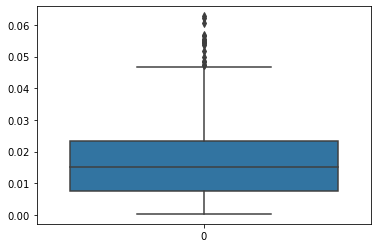

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             8908
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        251
Service                     4
TGS                     12606
TGT                      3179
WorkstationLock           641
WorkstationUnlock         861
dtype: int64


In [48]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

### Results

- Currently in use: 27.77/29.18
- Dropout: 29.84/29.18
- Reducing to 6: 28.04/29.18
- Reducing by 1: 29.18/29.18
- Double Stacked: 30.10/29.18
- Quadruple Stacked: 30.17/29.18
- RELU: 29.11/29.18
- Sigmoid: 27.97/28.92